In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425350 sha256=76f65278820eef8c65125255ae1ce8bf1d1297054b92382ba7b295b6f4c65576
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType, IntegerType, FloatType, 
    DoubleType, StringType, TimestampType)

from pyspark.sql.functions import (
    sum, col, count, length, size, split,
    udf, when, isnan, explode, array_min,
    array_max, array_distinct, to_timestamp,
    explode, countDistinct, mean, year, month
)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from tabulate import tabulate

In [4]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "10g") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .appName("Yelp Review Sense - EDA Business") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/26 15:49:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Define the JDBC connection details
jdbc_url = "jdbc:postgresql://intentionally-removed.amazonaws.com/yelpreviewsense"
db_table = ""
db_user = "postgres"
db_password = ""

# Specify the read options
read_options = {
    "url": jdbc_url,
    "driver": "org.postgresql.Driver",
    "dbtable": f"""
        (SELECT
            business_id,
            business_name,
            business_city,
            business_state,
            business_postal_code,
            business_categories,
            business_latitude,
            business_longitude,
            business_stars,
            business_review_count
        FROM {db_table}) AS review_data
    """,
    "user": db_user,
    "password": db_password,
}

# Read the table into a PySpark DataFrame
df = spark.read.format("jdbc").options(**read_options).load()
df.limit(5).toPandas()

,business_id,business_name,business_city,business_state,business_postal_code,business_categories,business_latitude,business_longitude,business_stars,business_review_count
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,93101,"Doctors, Traditional Chinese Medicine, Naturop...",34.426678,-119.711197,5.0,7
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,63123,"Shipping Centers, Local Services, Notaries, Ma...",38.551125,-90.335693,3.0,15
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,85711,"Department Stores, Shopping, Fashion, Home & G...",32.223236,-110.880455,3.5,22
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,19107,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",39.955505,-75.155563,4.0,80
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,18054,"Brewpubs, Breweries, Food",40.338184,-75.471657,4.5,13


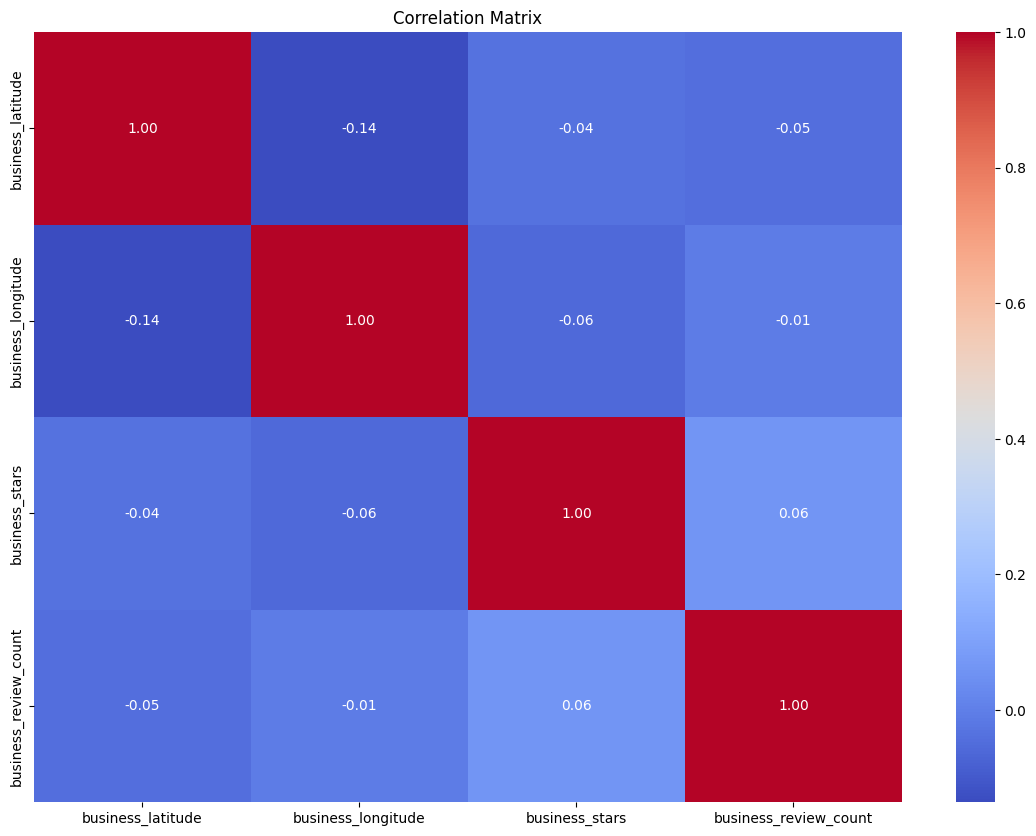

In [6]:
# Correlation Matrix

numerical_cols = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'float', 'double']]
correlation_matrix = df.select([col(c).cast("float") for c in numerical_cols]).toPandas().corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The correlation analysis reveals subtle relationships among the variables. Geographical coordinates exhibit weak correlations with business stars, suggesting that the geographical location alone does not significantly impact star ratings. However, a slight negative correlation between latitude and longitude implies businesses are somewhat more dispersed in the north-south direction. Notably, a modest positive correlation between business stars and review count indicates that businesses with higher star ratings tend to attract more reviews, though this association is not particularly strong. Overall, these findings suggest that while there are some connections, a myriad of factors likely contribute to business success and customer feedback beyond geographical location.

In [7]:
# Visualizing Business Counts and Average Ratings Across US States

state_counts_ratings = df.groupBy('business_state').agg(
    mean('business_stars').alias('average_rating'),
    count('business_id').alias('count')
)

pandas_state_counts_ratings = state_counts_ratings.toPandas()
pandas_state_counts_ratings['average_rating'] = pandas_state_counts_ratings['average_rating'].round(2)

state_code_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

pandas_state_counts_ratings['state_name'] = pandas_state_counts_ratings['business_state'].map(state_code_to_name)

# Create a choropleth map
fig = px.choropleth(
    pandas_state_counts_ratings,
    locations='business_state',
    locationmode='USA-states',
    color='count',
    scope='usa',
    color_continuous_scale='Blues',
    title='Businesses per US State',
    labels={'count': 'Business Count', 'state_name': 'State', 'average_rating': 'Average Rating'},
    hover_data={'business_state': False, 'state_name': False, 'count': True, 'average_rating': True},
    hover_name='state_name'
)

fig.update_traces(colorbar=dict(title='Business Count', tickformat=',', tickvals=[0, 50000, 100000, 150000]))
fig.show()

**Please Note**: This is an interactive plotly map. Please follow this [nbviewer](https://nbviewer.org/github/yashraizada/yelp-review-sense/blob/main/notebooks/EDA%20-%20Business.ipynb) link to see.

The analysis of businesses across US states reveals the following:

* The concentration of businesses is notably high on the east coast, with Pennsylvania having the highest number of businesses at nearly 34k, and Florida closely following with 24k.

* The map emphasizes a strong presence of businesses in coastal areas, while the Midwest shows lower business counts in the dataset.

* States with a higher number of businesses tend to have an average rating of 3.5. However, it is noteworthy that California, although having slightly fewer businesses, boast the highest average rating of 4. On the other hand, New Jersey, with around 8.5k businesses, exhibits an average rating of less than 3.5.

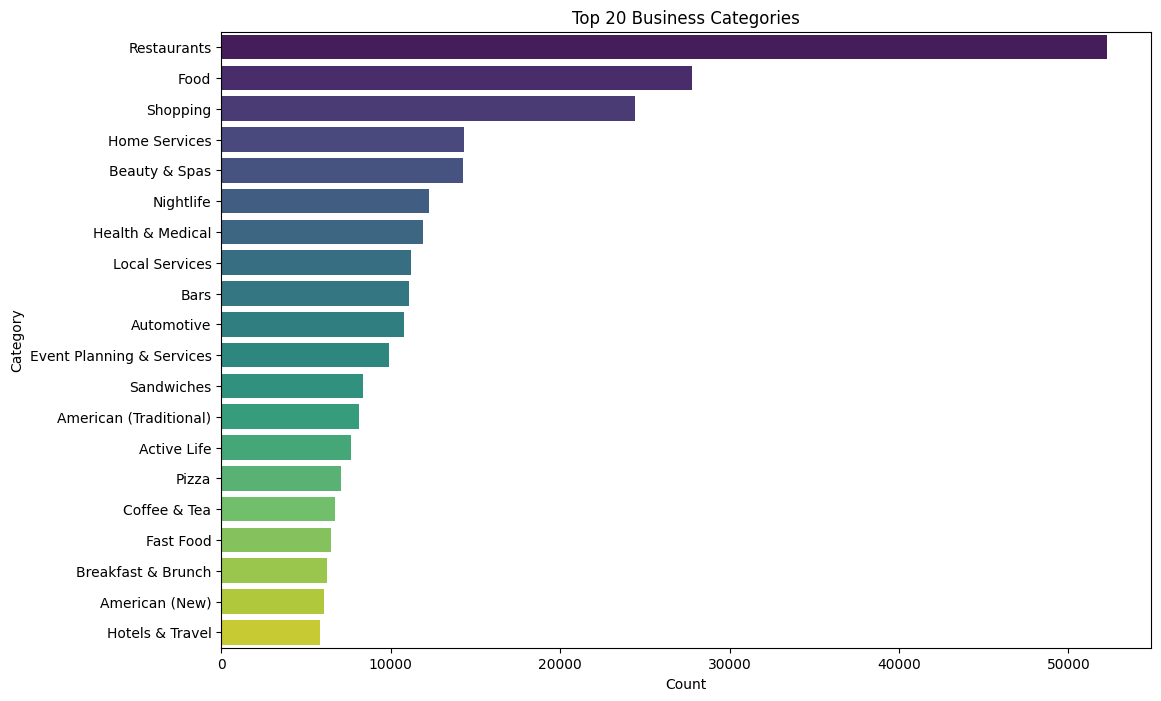

In [8]:
# Visualizing the Top 20 Business Categories based on Ratings

df_categories = df.withColumn('category', explode(split('business_categories', ', ')))
df_categories_pd = df_categories.select('business_id', 'business_stars', 'category').toPandas()
top_categories = df_categories_pd['category'].value_counts().reset_index()
top_categories.columns = ['category', 'count']

# Visualize the top categories
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='category', data=top_categories.head(20), palette='viridis')
plt.title('Top 20 Business Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

Based on the above bar chart, the following is observed:

* Categories such as "Restaurants", "Food", "Bars", etc., collectively contribute to over 17% of the total businesses, highlighting the prevalence of dining establishments and indicating the dominance of food-related services in the dataset.

* "Home Services" and "Health & Medical" also emerge as prominent categories, indicating a substantial presence of businesses catering to both domestic needs and healthcare services.

* The substantial representation of "Automotive" category suggests a considerable demand for and engagement with automotive-related establishments

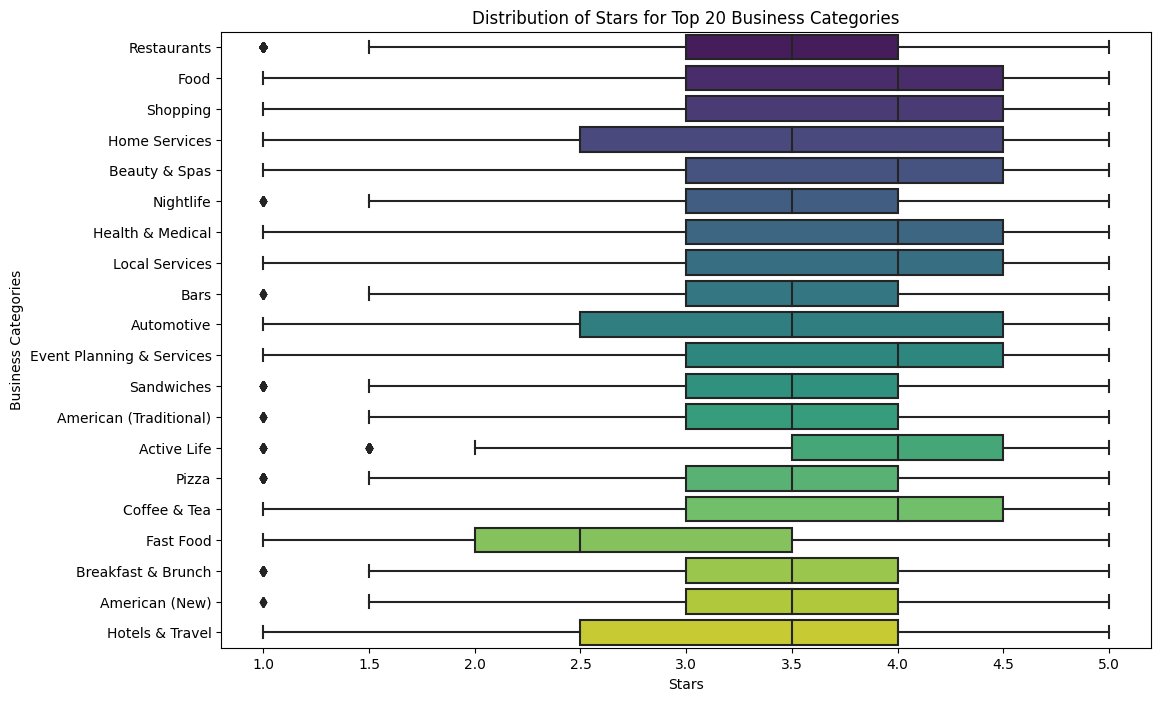

In [9]:
# Distribution of stars for top 20 business categories

top20_categories = top_categories.head(20)['category'].tolist()
df_top20_categories = df_categories_pd[df_categories_pd['category'].isin(top20_categories)]

# Visualize the distribution
plt.figure(figsize=(12, 8))
sns.boxplot(x='business_stars', y='category', data=df_top20_categories, order=top20_categories, orient='h', palette='viridis')
plt.title('Distribution of Stars for Top 20 Business Categories')
plt.xlabel('Stars')
plt.ylabel('Business Categories')
plt.show()

In [10]:
# Analyzing Top 20 Restaurants Based on Review Count and Average Rating

df_restaurants = df.filter(col('business_categories').contains('Restaurants'))
restaurant_metrics = (
    df_restaurants
    .groupBy('business_id', 'business_name')
    .agg(
        mean('business_stars').alias('average_rating'),
        sum('business_review_count').alias('total_reviews')
    )
)

top_20 = restaurant_metrics.orderBy(['total_reviews', 'average_rating'], ascending=[False, False]).limit(20)
top_20_pd = top_20.toPandas()

print('Top 20 Most Reviewed and Highest Average Rating Restaurants:')
print(tabulate(top_20_pd, headers='keys', tablefmt='pretty', showindex=False))

Top 20 Most Reviewed and Highest Average Rating Restaurants:
+------------------------+------------------------------------+----------------+---------------+
|      business_id       |           business_name            | average_rating | total_reviews |
+------------------------+------------------------------------+----------------+---------------+
| _ab50qdWOk0DdB6XOrBitw |         Acme Oyster House          |      4.0       |     7568      |
| ac1AeYqs8Z4_e2X5M3if2A |            Oceana Grill            |      4.0       |     7400      |
| GXFMD0Z4jEVZBCsbPf4CTQ | Hattie B’s Hot Chicken - Nashville |      4.5       |     6093      |
| ytynqOUb3hjKeJfRj5Tshw |      Reading Terminal Market       |      4.5       |     5721      |
| oBNrLz4EDhiscSlbOl8uAw |     Ruby Slipper - New Orleans     |      4.5       |     5193      |
| iSRTaT9WngzB8JJ2YKJUig |        Mother's Restaurant         |      3.5       |     5185      |
| VQcCL9PiNL_wkGf-uF3fjg |            Royal House             |   

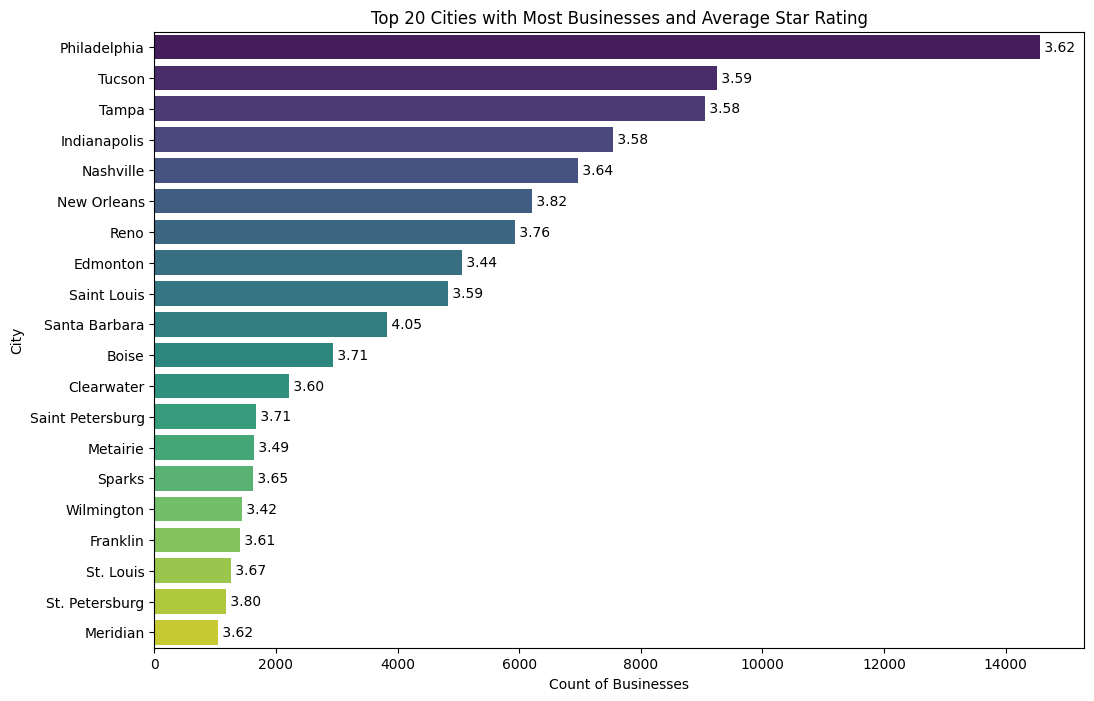

In [12]:
# Exploring Top 20 Cities by Business Count and Average Star Rating

top_cities = df.groupBy('business_city').agg({'business_stars': 'mean', 'business_id': 'count'}).withColumnRenamed('avg(business_stars)', 'business_stars_avg').orderBy('count(business_id)', ascending=False).limit(20).toPandas()

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='count(business_id)', y='business_city', data=top_cities, palette='viridis')
for idx, p in enumerate(ax.patches):
    avg_stars = top_cities.loc[idx, 'business_stars_avg']
    ax.annotate(f' {avg_stars:.2f}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', color='black')

plt.title('Top 20 Cities with Most Businesses and Average Star Rating')
plt.xlabel('Count of Businesses')
plt.ylabel('City')
plt.show()

/tmp/ipykernel_32/3721842706.py:13: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



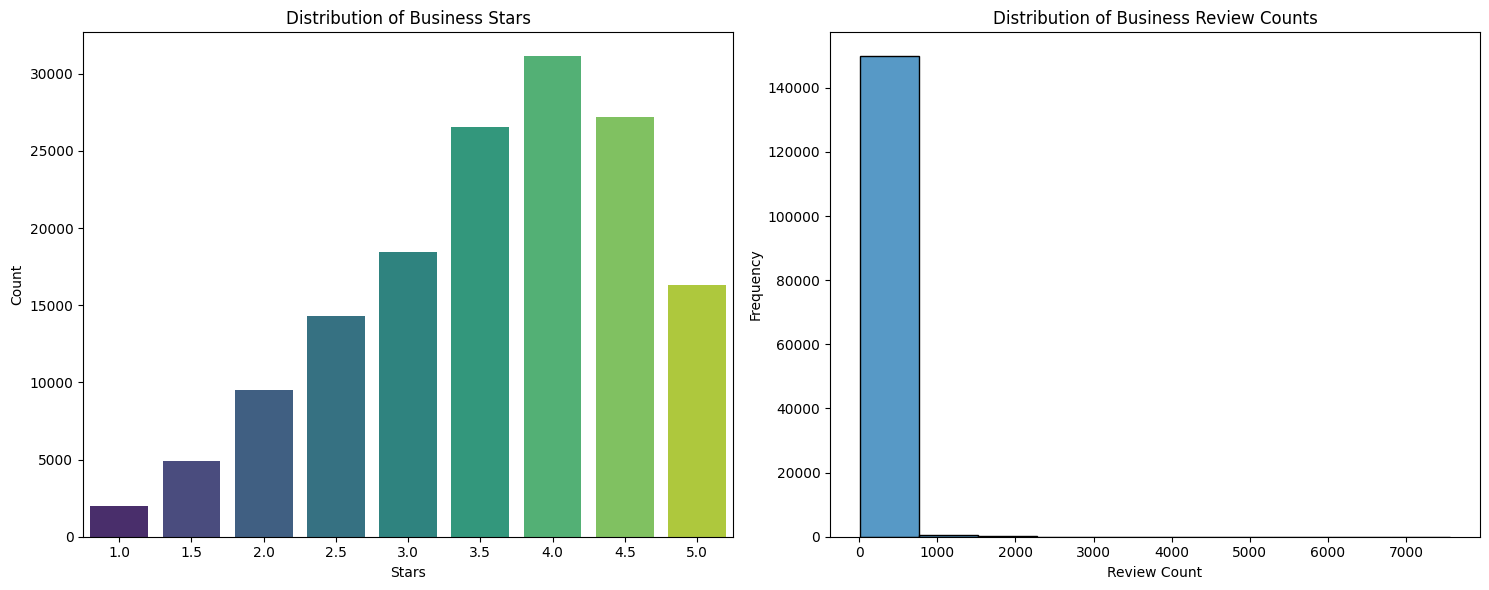

In [13]:
# Analyzing Distribution of Business Stars and Review Counts

selected_columns = ['business_stars', 'business_review_count']
selected_columns_df_pd = df.select(selected_columns).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualize the distribution of business stars as a bar plot with 'viridis' color palette
sns.countplot(x='business_stars', data=selected_columns_df_pd, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Business Stars')
axes[0].set_xlabel('Stars')
axes[0].set_ylabel('Count')

# Visualize the distribution of review counts with 'viridis' color palette
sns.histplot(selected_columns_df_pd['business_review_count'], bins=10, ax=axes[1], palette='viridis')
axes[1].set_title('Distribution of Business Review Counts')
axes[1].set_xlabel('Review Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

* **Distribution of Business Stars**: The distribution of business stars reveals that businesses with various star ratings are present in the dataset. The majority of businesses have star ratings between 3.0 and 4.5, with a significant number of businesses rated at 4.0. On the other hand, businesses with lower star ratings (1.0 to 2.0) and higher star ratings (5.0) are less represented, suggesting that extreme ratings are less common in the dataset

* **Distribution of Business Review Counts**: The majority of businesses have a relatively low number of reviews, as indicated by the plot. However, there are notable outliers with significantly higher review counts, as evidenced by the maximum value of 7000. The distribution is right-skewed, with a long tail to the right, suggesting that while many businesses have a modest number of reviews, there are some with exceptionally high review counts

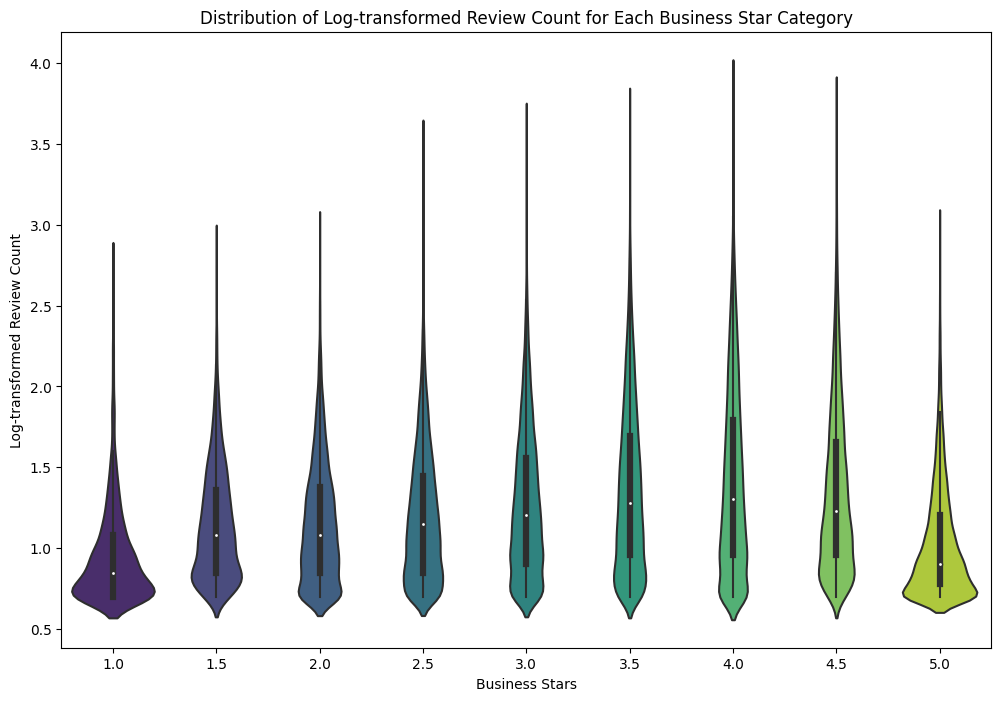

In [14]:
# Exploring the Relationship Between Business Stars and Log-transformed Review Counts

stars_counts_df = df.select(['business_stars', 'business_review_count']).toPandas()
stars_counts_df['log_review_count'] = stars_counts_df['business_review_count'].apply(lambda x: max(1, x)).apply(lambda x: np.log10(x))

# Violin Plot: Business Stars vs. Log-transformed Review Count
plt.figure(figsize=(12, 8))
sns.violinplot(x='business_stars', y='log_review_count', data=stars_counts_df, palette='viridis')
plt.title('Distribution of Log-transformed Review Count for Each Business Star Category')
plt.xlabel('Business Stars')
plt.ylabel('Log-transformed Review Count')
plt.show()

Based on the distribution of log-transformed review counts across different business star categories, the following observations can be made:

* **Variability Across Star Categories**: As business stars increase, there is an increase in both the mean and median log-transformed review counts. This suggests that businesses with higher star ratings tend to attract more reviews.

* **Differences in User Engagement**: The standard deviation of log-transformed review counts increases with higher star ratings, implying greater variability in user engagement for businesses with better ratings.

* **Consistency in Higher Star Ratings**: Businesses with star ratings between 3.0 and 5.0 exhibit higher mean log-transformed review counts, indicating a consistent trend of higher engagement and reviews for businesses with favorable star ratings

* **Variability in Lower Star Ratings**: For businesses with star ratings between 1.0 and 2.5, there is more variability in log-transformed review counts, suggesting that lower-rated businesses may experience varying levels of engagement.

* High-rated businesses (with 5 Star Rating) could include newly established ones that haven't been operating long enough to accumulate a large number of reviews. Newer businesses, even if highly rated, might have a lower review count. Also, in certain industries or types of businesses, a 5-star rating might be more difficult to maintain due to the inherent subjectivity of reviews

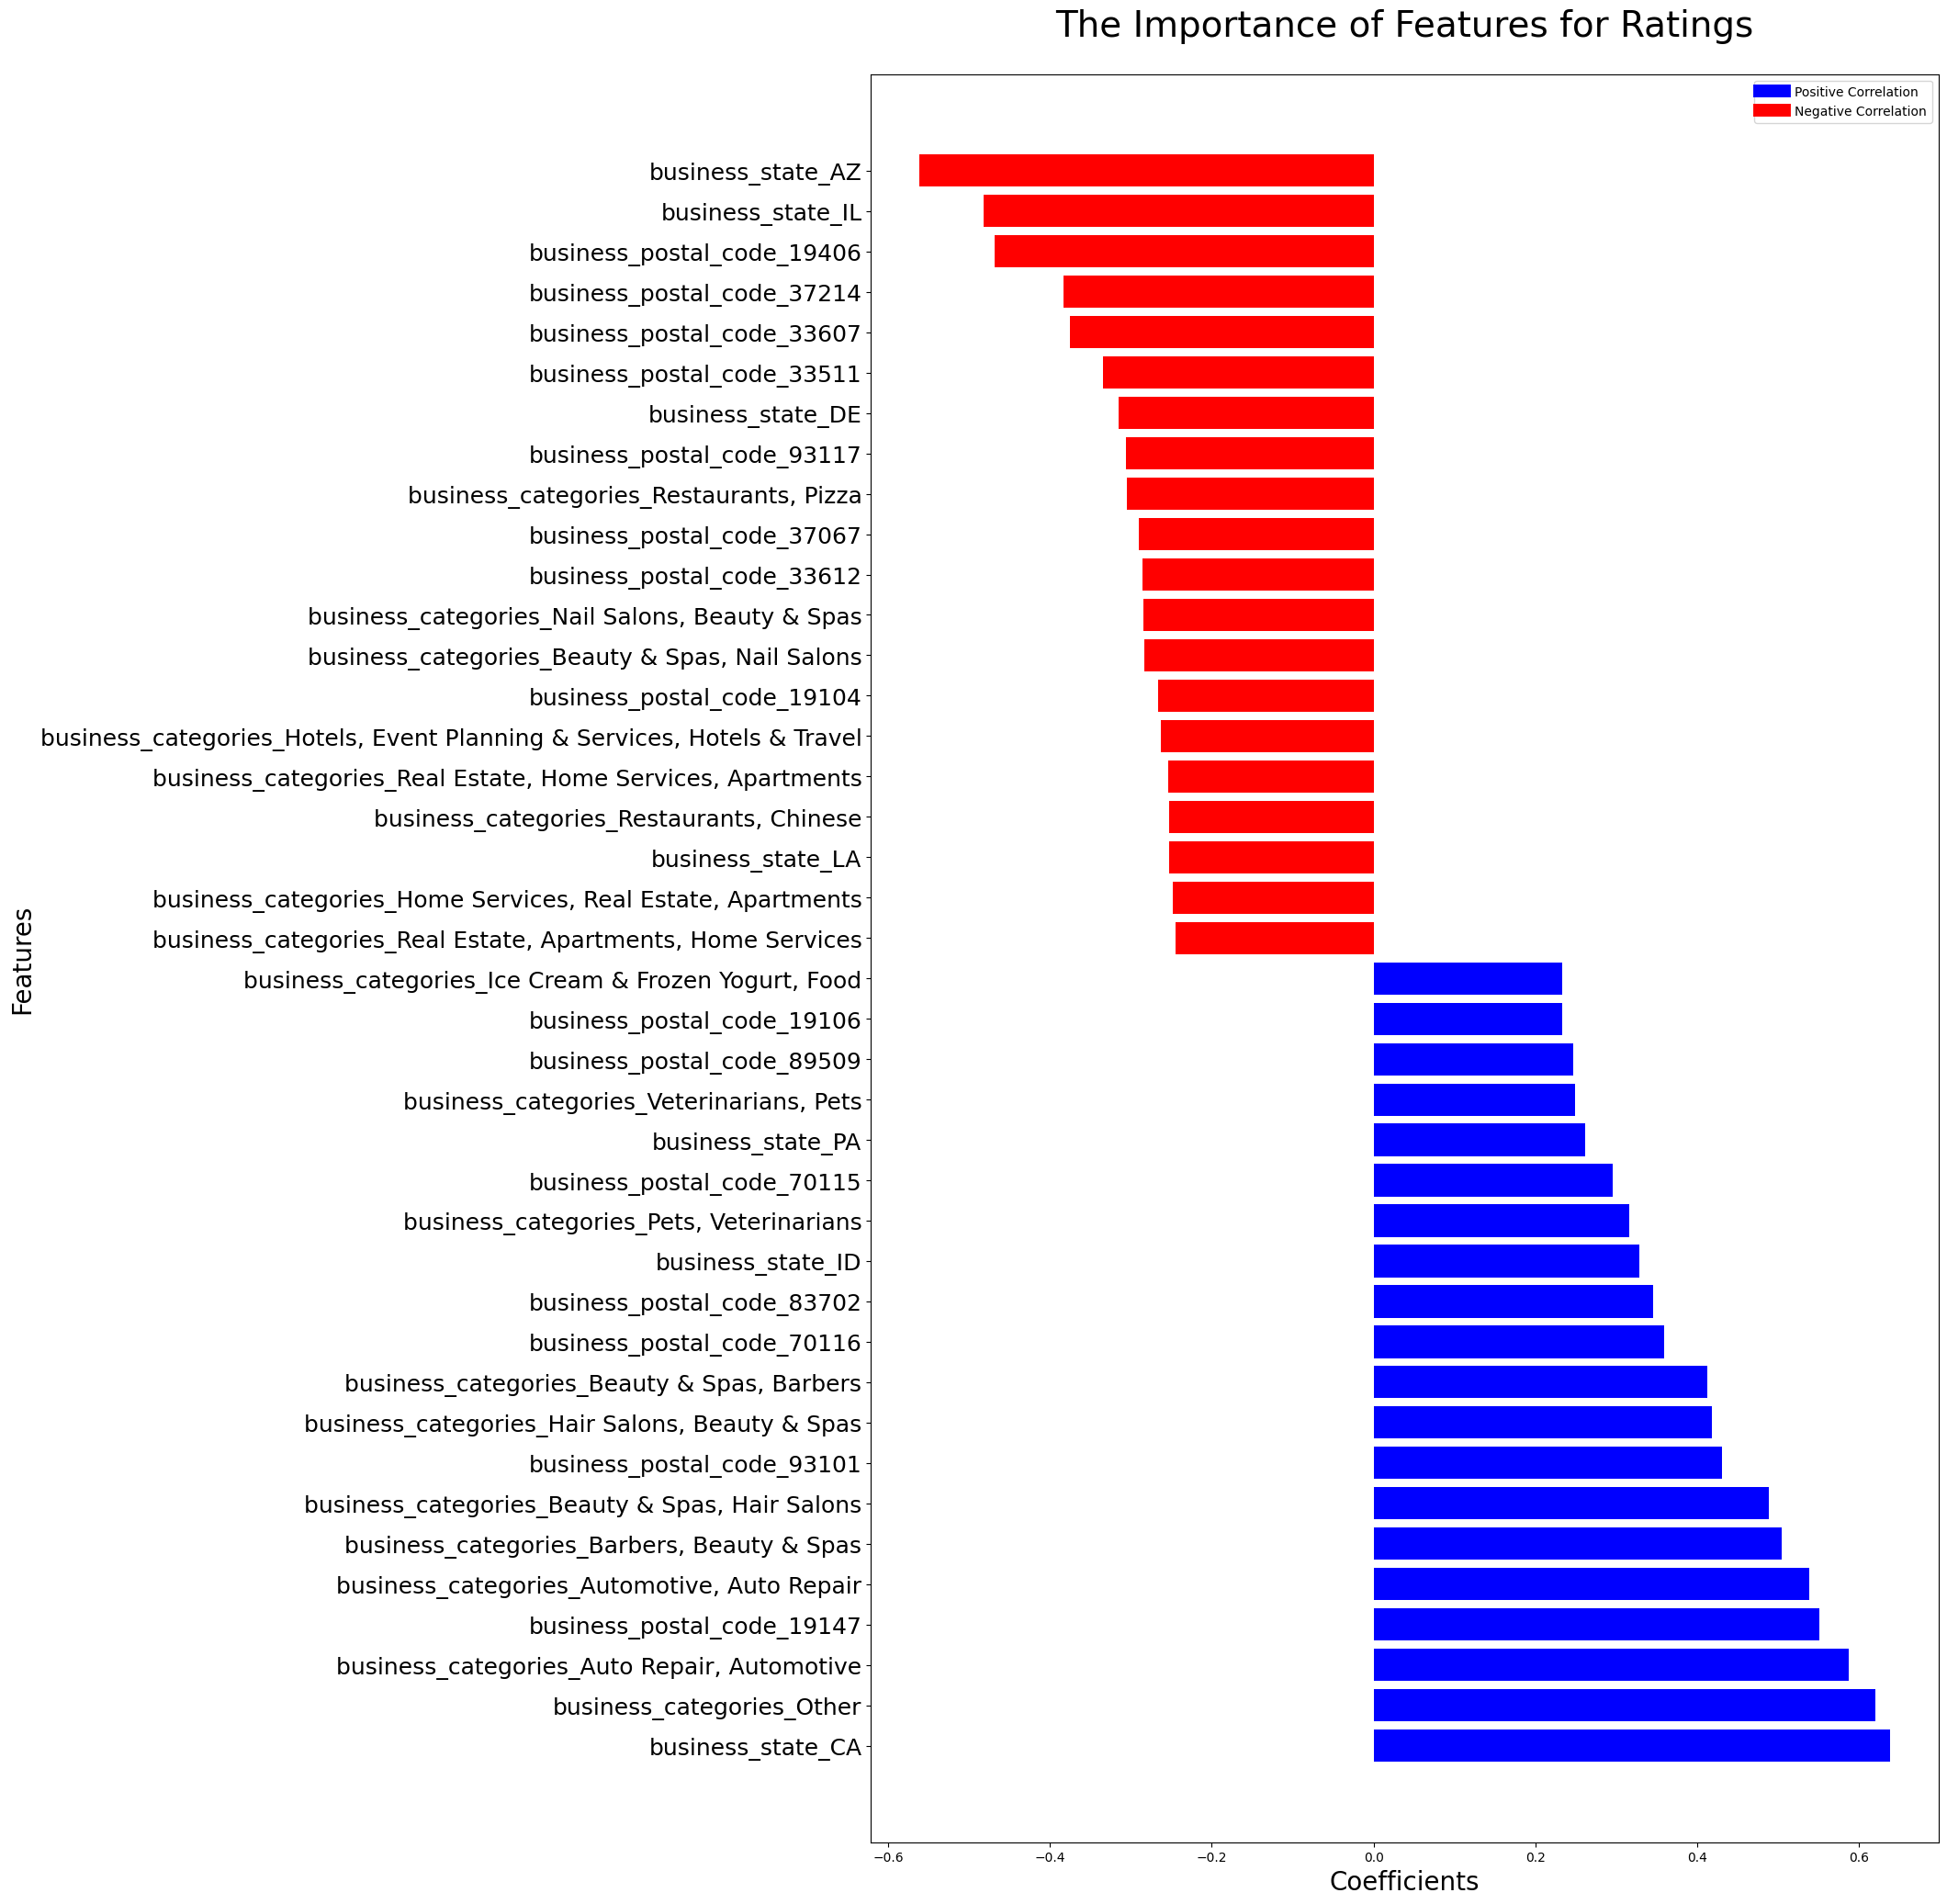

In [16]:
# Identifying Key Features Influencing Business Star Ratings

training_df = df.toPandas()

threshold = 3.5
training_df['business_stars_binary'] = np.where(training_df['business_stars'] > threshold, 1, 0)
selected_columns = ['business_stars_binary', 'business_review_count', 'business_state', 'business_postal_code', 'business_categories', 'business_latitude', 'business_longitude']
training_df_selected = training_df[selected_columns].dropna()

# Get the top 20 categories for each feature in categorical_columns
top_categories = {}
for column in ['business_state', 'business_postal_code', 'business_categories']:
    top_categories[column] = training_df_selected[column].value_counts().nlargest(50).index.tolist()

# Replace values not in the top 20 with a placeholder value
for column, categories in top_categories.items():
    training_df_selected[column] = np.where(training_df_selected[column].isin(categories), training_df_selected[column], 'Other')

categorical_columns = ['business_state', 'business_postal_code', 'business_categories']
training_df_encoded = pd.get_dummies(training_df_selected, columns=categorical_columns, drop_first=True)

label_encoder = LabelEncoder()
training_df_encoded['business_stars_binary'] = label_encoder.fit_transform(training_df_encoded['business_stars_binary'])

X = training_df_encoded.drop('business_stars_binary', axis=1)
y = training_df_encoded['business_stars_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

feature_names = X.columns
coefficients = model.coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot coefficients with blue for positive and red for negative
plt.figure(figsize=(15, 25))
plt.title('The Importance of Features for Ratings', fontsize=28, pad=30)
top_positive_features = coef_df_sorted.head(20)
top_negative_features = coef_df_sorted.tail(20)
top_features = pd.concat([top_positive_features, top_negative_features])
bar_colors = np.where(top_features['Coefficient'] > 0.0, 'blue', 'red')
plt.barh(top_features['Feature'], top_features['Coefficient'], color=bar_colors)
legend_labels = [plt.Line2D([0], [0], color='blue', lw=10, label='Positive Correlation'),
                 plt.Line2D([0], [0], color='red', lw=10, label='Negative Correlation')]

plt.xlabel('Coefficients', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.yticks(fontsize=18)
plt.legend(handles=legend_labels, loc='upper right')
plt.show()

Based on the logistic regression analysis, the top 20 positive coefficients indicate features that positively contribute to the likelihood of a business having a high star rating. Here are some notable findings:

* **California Dominance**: The state of California (business_state_CA) emerges as the most influential factor, with a positive coefficient of 0.64. This suggests that businesses in California tend to receive higher ratings.

* **Category Specifics**: The presence of specific business categories positively impacts ratings. Categories like "Auto Repair, Automotive," "Barbers, Beauty & Spas," and "Hair Salons, Beauty & Spas" demonstrate positive correlations, suggesting that businesses in these categories tend to receive higher ratings.

* **Geographic Influence**: Certain postal codes, such as 19147, 93101, 70116, and 83702, show positive correlations, indicating that businesses in these areas are more likely to have higher ratings.

On the flip side, the top 20 negative coefficients represent features with a negative correlation to ratings:

* **Location Matters**: Geographical locations, particularly states like Arizona (business_state_AZ), Delaware (business_state_DE), Illinois (business_state_IL), as well as specific postal codes (e.g., 19406, 37214, 33607, 33511, etc.), show strong negative correlations, suggesting that businesses in these states/areas may receive lower ratings.

* **Category Challenges**: Specific business categories, including "Restaurants, Chinese" and "Nail Salons, Beauty & Spas" exhibit negative correlations, indicating potential challenges in these categories regarding rating outcomes.

